# Bank Marketing Campaign Prediction Model

**Project:** Binary classification to predict term deposit subscription  
**Dataset:** Bank Marketing from Kaggle (41,188 samples, 20 features)  
**Source:** https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing  
**Goal:** Identify high-potential clients for marketing campaigns  
**Business Value:** Reduce marketing costs, increase conversion rate

## Setup Environment
Import libraries and set random seeds for reproducibility.

In [1]:
# Setup Environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import os
import warnings

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             accuracy_score, roc_auc_score, roc_curve,
                             classification_report, confusion_matrix)

# Models
import lightgbm as lgb

# Settings
warnings.filterwarnings("ignore")
np.random.seed(42)

print("Environment setup completed")
print(f"LightGBM version: {lgb.__version__}")

Environment setup completed
LightGBM version: 4.6.0


## 1. Load Dataset
Load the Bank Marketing dataset from UCI repository.
Initial exploration: shape, missing values, target distribution.

In [ ]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Missing values: {df.isnull().sum().sum()}")

target_dist = df['y'].value_counts()
print(f"Target distribution: No={target_dist['no']}, Yes={target_dist['yes']}")
print(f"Imbalance ratio: {target_dist['no'] / target_dist['yes']:.1f}:1")

# Display sample
df.head()

Dataset: 41188 rows, 21 columns
Missing values: 0
Target distribution: No=36548, Yes=4640
Imbalance ratio: 7.9:1


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## 2. Data Understanding
- Identify numerical vs categorical features
- Basic statistics for numerical features
- Unique values for categorical features
- Target variable analysis (7.9:1 imbalance ratio)

In [ ]:
print("DATA UNDERSTANDING - BASIC STATISTICS")

# Check missing values
print("\n1. Missing Values Analysis:")
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("   No missing values found in the dataset")
else:
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage (%)': missing_percent
    })
    print(missing_df[missing_df['Missing Values'] > 0])

# Feature types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'y' in numerical_cols:
    numerical_cols.remove('y')

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'y' in categorical_cols:
    categorical_cols.remove('y')

print(f"\n2. Feature Types:")
print(f"   Numerical features: {len(numerical_cols)}")
print(f"   Categorical features: {len(categorical_cols)}")

print("\n3. Numerical Features Summary:")
print(df[numerical_cols].describe().round(2))

print("\n4. Categorical Features Unique Values:")
for col in categorical_cols[:5]:  # Show first 5 only
    unique_vals = df[col].unique()
    print(f"   {col}: {len(unique_vals)} unique values - {list(unique_vals)[:3]}...")

# Target distribution
print("\n5. Target Variable Distribution:")
target_dist = df['y'].value_counts()
target_percent = df['y'].value_counts(normalize=True) * 100
target_df = pd.DataFrame({
    'Count': target_dist,
    'Percentage': target_percent.round(2)
})
print(target_df)
print(f"\n   Imbalance ratio: {target_dist['no'] / target_dist['yes']:.1f}:1")

DATA UNDERSTANDING - BASIC STATISTICS

1. Missing Values Analysis:
   No missing values found in the dataset

2. Feature Types:
   Numerical features: 10
   Categorical features: 10

3. Numerical Features Summary:
            age  duration  campaign     pdays  previous  emp.var.rate  \
count  41188.00  41188.00  41188.00  41188.00  41188.00      41188.00   
mean      40.02    258.29      2.57    962.48      0.17          0.08   
std       10.42    259.28      2.77    186.91      0.49          1.57   
min       17.00      0.00      1.00      0.00      0.00         -3.40   
25%       32.00    102.00      1.00    999.00      0.00         -1.80   
50%       38.00    180.00      2.00    999.00      0.00          1.10   
75%       47.00    319.00      3.00    999.00      0.00          1.40   
max       98.00   4918.00     56.00    999.00      7.00          1.40   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
count        41188.00       41188.00   41188.00     41188.00  
me

## 3. Exploratory Data Analysis (Visualization)
- Target distribution (bar & pie charts)
- Distribution of key numerical features
- Categorical features distribution (top 10)
- Correlation heatmap and top correlated features with target

EXPLORATORY DATA ANALYSIS - VISUALIZATION


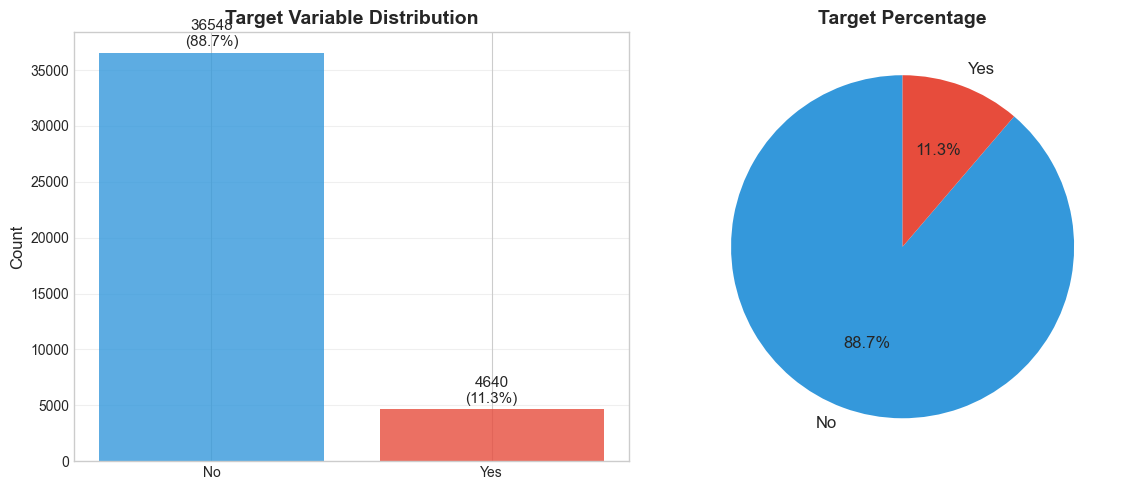

In [ ]:
print("EXPLORATORY DATA ANALYSIS - VISUALIZATION")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Target Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
target_counts = df['y'].value_counts()
bars = ax1.bar(['No', 'Yes'], target_counts.values, color=['#3498db', '#e74c3c'], alpha=0.8)
ax1.set_title('Target Variable Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 300,
            f'{int(height)}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=11)

# Pie chart
ax2.pie(target_counts.values, labels=['No', 'Yes'], autopct='%1.1f%%',
        colors=['#3498db', '#e74c3c'], startangle=90,
        textprops={'fontsize': 12})
ax2.set_title('Target Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Distribution of Key Numerical Features:


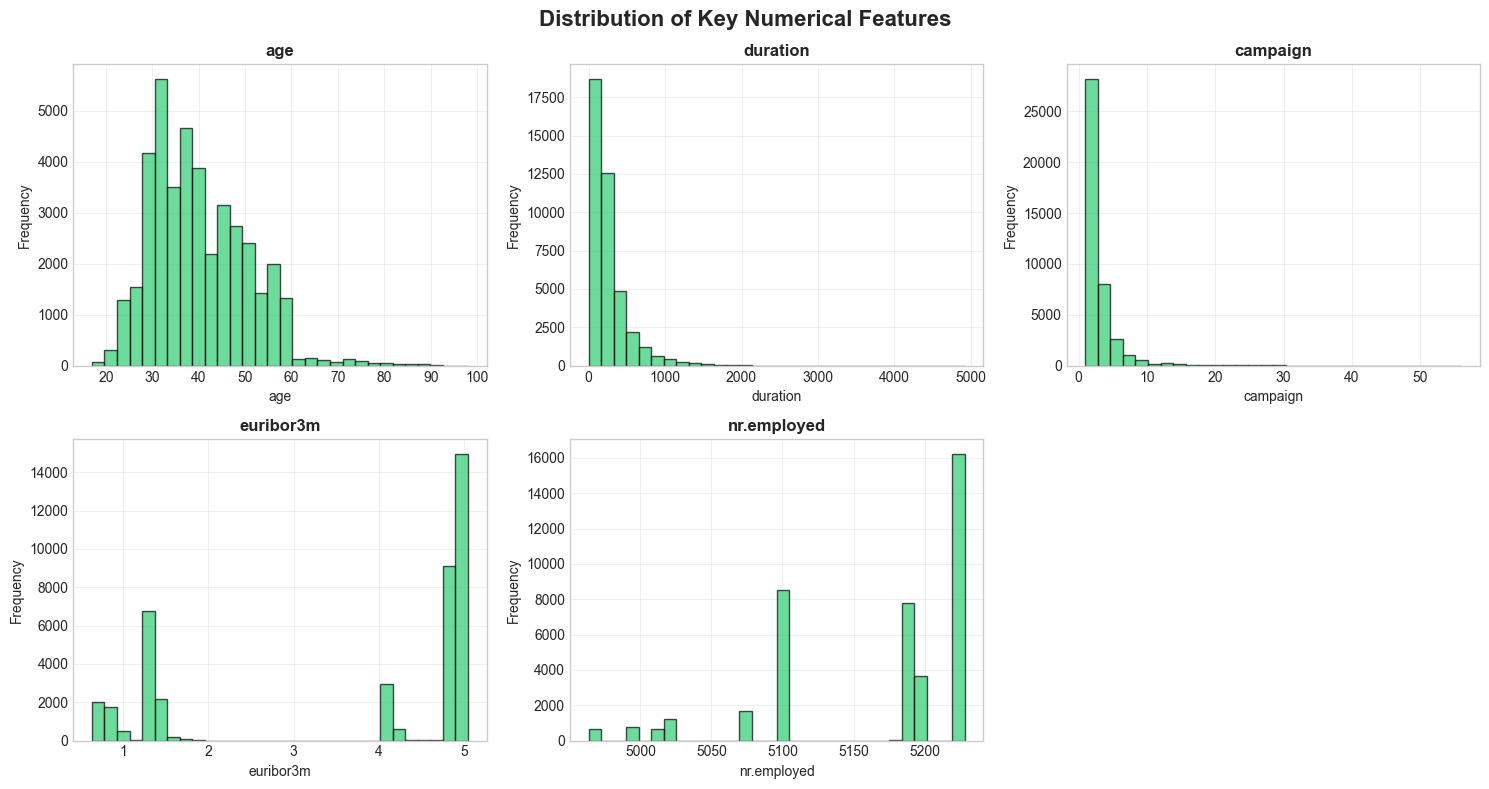

In [5]:
# 2. Distribution of Key Numerical Features
print("\nDistribution of Key Numerical Features:")

key_numerical = ['age', 'duration', 'campaign', 'euribor3m', 'nr.employed']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(key_numerical):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='#2ecc71')
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

# Remove empty subplot
fig.delaxes(axes[5])

plt.suptitle('Distribution of Key Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Top Categorical Features:


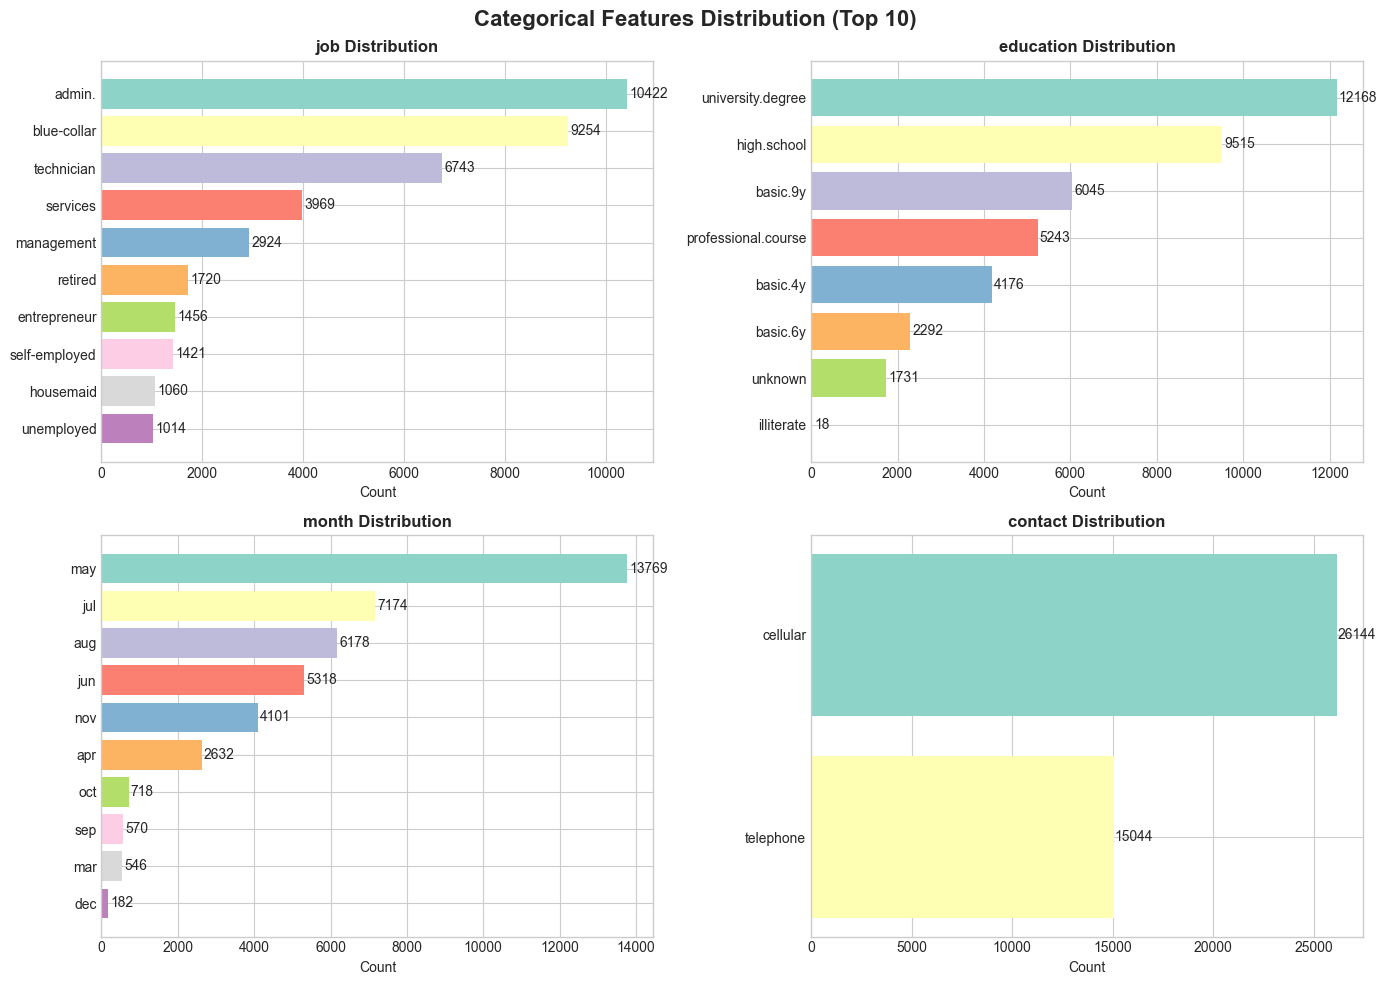

In [6]:
# 3. Categorical Features Distribution
print("\nTop Categorical Features:")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
top_categorical = ['job', 'education', 'month', 'contact']

for idx, col in enumerate(top_categorical):
    ax = axes[idx//2, idx%2]
    value_counts = df[col].value_counts().head(10)
    
    bars = ax.barh(range(len(value_counts)), value_counts.values, 
                   color=plt.cm.Set3(np.arange(len(value_counts))))
    ax.set_yticks(range(len(value_counts)))
    ax.set_yticklabels(value_counts.index)
    ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Count')
    ax.invert_yaxis()
    
    # Add count labels
    for i, v in enumerate(value_counts.values):
        ax.text(v + 50, i, str(v), va='center', fontsize=10)

plt.suptitle('Categorical Features Distribution (Top 10)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Feature Correlation Analysis:


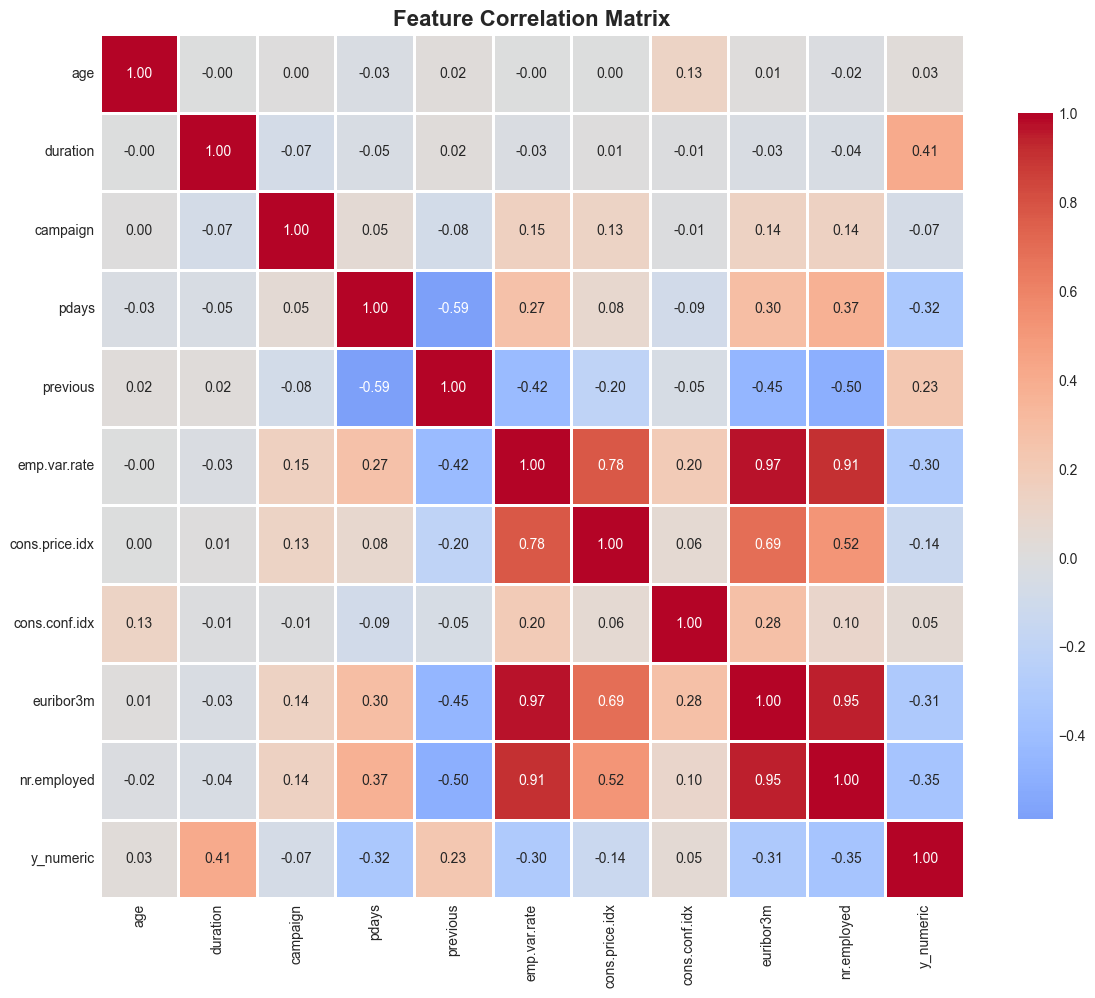

In [7]:
# 4. Correlation Heatmap
print("\nFeature Correlation Analysis:")

# Encode target for correlation
df_corr = df.copy()
df_corr['y_numeric'] = df_corr['y'].map({'no': 0, 'yes': 1})

# Select numerical features for correlation
corr_features = numerical_cols + ['y_numeric']
corr_matrix = df_corr[corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [8]:
# Top correlations with target
print("\nTop 5 Features Correlated with Target:")
top_corr = corr_matrix['y_numeric'].abs().sort_values(ascending=False)[1:6]
print(top_corr.round(3))


Top 5 Features Correlated with Target:
duration        0.405
nr.employed     0.355
pdays           0.325
euribor3m       0.308
emp.var.rate    0.298
Name: y_numeric, dtype: float64


## 4. Remove Data Leakage Features
Remove features that contain information only available AFTER campaign contact:
- `duration` (call duration)
- `pdays` (days since last contact)
- `previous` (number of previous contacts)
- `poutcome` (outcome of previous campaign)

Result: 16 features remaining for modeling.

In [ ]:
leakage_features = ['duration', 'pdays', 'previous', 'poutcome']
df_clean = df.drop(columns=leakage_features)

# Encode target
df_clean['y'] = df_clean['y'].map({'no': 0, 'yes': 1})

# Update feature lists
numerical_cols = [col for col in numerical_cols if col in df_clean.columns]
categorical_cols = [col for col in categorical_cols if col in df_clean.columns]

print(f"Original shape: {df.shape}")
print(f"Clean shape: {df_clean.shape}")
print(f"Removed {len(leakage_features)} leakage features")
print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"Target - 0: {(df_clean['y'] == 0).sum()}, 1: {(df_clean['y'] == 1).sum()}")

Original shape: (41188, 21)
Clean shape: (41188, 17)
Removed 4 leakage features
Numerical features: 7
Categorical features: 9
Target - 0: 36548, 1: 4640


## 5. Feature Engineering
#### Create 25 new features to capture hidden patterns:

Age Features (4)
- `is_senior`, `is_young`, `age_squared`, `age_bin`

Campaign Features (2)
- `single_call`, `high_campaign`

Economic Indicators (4)
- `euribor_low`, `euribor_high`, `confidence_low`, `confidence_high`

Interaction Features (10)
Product interactions between economic indicators

Ratio Features (5)
Ratios between economic indicators

**Total features after engineering: 41 (16 original + 25 new)**

In [ ]:
df_fe = df_clean.copy()

# Age features
df_fe['is_senior'] = (df_fe['age'] >= 60).astype(int)
df_fe['is_young'] = (df_fe['age'] <= 30).astype(int)
df_fe['age_squared'] = df_fe['age'] ** 2
df_fe['age_bin'] = pd.cut(df_fe['age'], bins=[0, 30, 40, 50, 60, 100], labels=[1, 2, 3, 4, 5]).astype(int)

# Campaign features
df_fe['single_call'] = (df_fe['campaign'] == 1).astype(int)
df_fe['high_campaign'] = (df_fe['campaign'] > 5).astype(int)

# Economic indicators
df_fe['euribor_low'] = (df_fe['euribor3m'] < 1).astype(int)
df_fe['euribor_high'] = (df_fe['euribor3m'] > 4).astype(int)
df_fe['confidence_low'] = (df_fe['cons.conf.idx'] < -40).astype(int)
df_fe['confidence_high'] = (df_fe['cons.conf.idx'] > -30).astype(int)

# Interactions
df_fe['campaign_x_empvar'] = df_fe['campaign'] * df_fe['emp.var.rate']
df_fe['euribor_x_confidence'] = df_fe['euribor3m'] * df_fe['cons.conf.idx']
df_fe['euribor_x_price'] = df_fe['euribor3m'] * df_fe['cons.price.idx']
df_fe['empvar_x_employed'] = df_fe['emp.var.rate'] * df_fe['nr.employed']
df_fe['age_x_campaign'] = df_fe['age'] * df_fe['campaign']
df_fe['age_x_empvar'] = df_fe['age'] * df_fe['emp.var.rate']
df_fe['campaign_x_confidence'] = df_fe['campaign'] * df_fe['cons.conf.idx']
df_fe['euribor_x_employed'] = df_fe['euribor3m'] * df_fe['nr.employed']
df_fe['price_x_confidence'] = df_fe['cons.price.idx'] * df_fe['cons.conf.idx']
df_fe['empvar_x_confidence'] = df_fe['emp.var.rate'] * df_fe['cons.conf.idx']

# Ratios
df_fe['economic_ratio'] = df_fe['euribor3m'] / (df_fe['cons.conf.idx'].abs() + 1)
df_fe['employment_ratio'] = df_fe['emp.var.rate'] / (df_fe['nr.employed'] / 1000)
df_fe['price_per_confidence'] = df_fe['cons.price.idx'] / (df_fe['cons.conf.idx'].abs() + 1)
df_fe['campaign_intensity'] = df_fe['campaign'] / (df_fe['age'] + 1)
df_fe['euribor_per_employed'] = df_fe['euribor3m'] / (df_fe['nr.employed'] / 1000)

# Update feature lists
X = df_fe.drop('y', axis=1)
y = df_fe['y']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Features after engineering: {df_fe.shape[1] - 1}")
print(f"New features added: {df_fe.shape[1] - df_clean.shape[1]}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Total features: {len(numerical_features) + len(categorical_features)}")

Features after engineering: 41
New features added: 25
Numerical features: 23
Categorical features: 9
Total features: 32


## 6.  Preprocessing Pipeline
- Train-test split (80-20 stratified)
- Create ColumnTransformer:
  - Numerical features: StandardScaler (23 features)
  - Categorical features: OneHotEncoder (9 features)
- Total features after encoding: 64

In [ ]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train positive rate: {y_train.mean():.4f}")
print(f"Test positive rate: {y_test.mean():.4f}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nProcessed train shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")
print(f"Total features after encoding: {X_train_processed.shape[1]}")

# Save feature lists for later use
feature_names = (
    numerical_features + 
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

Train set: (32950, 41)
Test set: (8238, 41)
Train positive rate: 0.1127
Test positive rate: 0.1126

Processed train shape: (32950, 64)
Processed test shape: (8238, 64)
Total features after encoding: 64


## 7. Model Training - LightGBM
- Calculate class weight for imbalance: scale_pos_weight = 7.88
- LightGBM parameters optimized for banking data
- Early stopping to prevent overfitting
- Model trained with 4 iterations (best iteration)

In [ ]:
# Calculate class weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale positive weight: {scale_pos_weight:.2f}")

# LightGBM parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'max_depth': 7,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

# Train model
model = lgb.LGBMClassifier(**lgb_params)

model.fit(
    X_train_processed, y_train,
    eval_set=[(X_test_processed, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

print(f"Model trained with {model.best_iteration_} iterations")

Scale positive weight: 7.88
Model trained with 4 iterations


## 8. Model Evaluation Results

**Optimal Threshold:** 0.24  
**F1 Score:** 0.5158  
**ROC AUC:** 0.8101  

### Performance Breakdown:
- **Precision:** 0.4835 (48% of predicted YES are correct)
- **Recall:** 0.5528 (55% of actual YES are detected)
- **Accuracy:** 0.8831 (88% overall correct)

### Class Performance:
- **Class 0 (NO):** High precision (0.94) and recall (0.93)
- **Class 1 (YES):** Moderate precision (0.48) and recall (0.55)

**Note:** Model favors recall over precision to catch more positive cases, suitable for marketing campaigns.

In [ ]:
# Get predictions
y_train_pred_proba = model.predict_proba(X_train_processed)[:, 1]
y_test_pred_proba = model.predict_proba(X_test_processed)[:, 1]

# Threshold optimization
thresholds = np.arange(0.05, 0.5, 0.005)
results = []

for thresh in thresholds:
    y_pred = (y_test_pred_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    results.append({
        'threshold': thresh,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })

results_df = pd.DataFrame(results)
best_idx = results_df['f1'].idxmax()
best_threshold = results_df.loc[best_idx, 'threshold']

# Final predictions with best threshold
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

# Metrics
print(f"Best threshold: {best_threshold:.3f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No', 'Yes']))

Best threshold: 0.240
F1 Score: 0.5158
Precision: 0.4835
Recall: 0.5528
Accuracy: 0.8831
ROC AUC: 0.8101

Classification Report:
              precision    recall  f1-score   support

          No       0.94      0.93      0.93      7310
         Yes       0.48      0.55      0.52       928

    accuracy                           0.88      8238
   macro avg       0.71      0.74      0.72      8238
weighted avg       0.89      0.88      0.89      8238



## 9. Save Model for Production
Save all artifacts required for deployment:
- Preprocessor pipeline
- Trained LightGBM model
- Feature configuration
- Threshold configuration
- Model metadata

Artifacts saved to: `models/artifacts/`

In [ ]:
BASE_DIR = "models"
ARTIFACT_DIR = os.path.join(BASE_DIR, "artifacts")
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Save preprocessor
preprocessor_path = os.path.join(ARTIFACT_DIR, "preprocessor.pkl")
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved to {preprocessor_path}")

# Save model
model_path = os.path.join(ARTIFACT_DIR, "lightgbm_model.pkl")
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

# Save feature config
feature_config = {
    'expected_columns': X.columns.tolist(),
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'target_mapping': {'no': 0, 'yes': 1},
    'best_threshold': best_threshold
}

feature_config_path = os.path.join(ARTIFACT_DIR, "feature_config.pkl")
joblib.dump(feature_config, feature_config_path)
print(f"Feature config saved to {feature_config_path}")

# Save metadata
metadata = {
    'model_info': {
        'model_type': 'LightGBM',
        'model_path': model_path,
        'preprocessor_path': preprocessor_path,
        'best_iteration': int(model.best_iteration_),
        'scale_pos_weight': float(scale_pos_weight)
    },
    'performance': {
        'f1_score': float(f1_score(y_test, y_test_pred)),
        'precision': float(precision_score(y_test, y_test_pred)),
        'recall': float(recall_score(y_test, y_test_pred)),
        'accuracy': float(accuracy_score(y_test, y_test_pred)),
        'roc_auc': float(roc_auc_score(y_test, y_test_pred_proba)),
        'best_threshold': float(best_threshold)
    },
    'data_info': {
        'train_size': int(len(X_train)),
        'test_size': int(len(X_test)),
        'positive_rate': float(y_train.mean()),
        'features_original': int(X.shape[1]),
        'features_processed': int(X_train_processed.shape[1])
    }
}

metadata_path = os.path.join(ARTIFACT_DIR, "model_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadata saved to {metadata_path}")

# Save threshold config
threshold_config = {
    'best_threshold': float(best_threshold),
    'deployment_threshold': float(best_threshold)
}

threshold_path = os.path.join(ARTIFACT_DIR, "threshold_config.json")
with open(threshold_path, 'w') as f:
    json.dump(threshold_config, f, indent=2)
print(f"Threshold config saved to {threshold_path}")

print("\nAll artifacts saved successfully.")
print(f"Artifacts location: {ARTIFACT_DIR}")

Preprocessor saved to models\artifacts\preprocessor.pkl
Model saved to models\artifacts\lightgbm_model.pkl
Feature config saved to models\artifacts\feature_config.pkl
Metadata saved to models\artifacts\model_metadata.json
Threshold config saved to models\artifacts\threshold_config.json

All artifacts saved successfully.
Artifacts location: models\artifacts


## 10. Create Inference Pipeline
Test the production inference pipeline with sample data.
Verify feature engineering and preprocessing work correctly.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def engineer_features(input_df):
    """
    Apply feature engineering to input data.
    Must match exactly with training feature engineering.
    """
    df = input_df.copy()
    
    # Age features
    df['is_senior'] = (df['age'] >= 60).astype(int)
    df['is_young'] = (df['age'] <= 30).astype(int)
    df['age_squared'] = df['age'] ** 2
    df['age_bin'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], 
                          labels=[1, 2, 3, 4, 5]).astype(int)
    
    # Campaign features
    df['single_call'] = (df['campaign'] == 1).astype(int)
    df['high_campaign'] = (df['campaign'] > 5).astype(int)
    
    # Economic indicators
    df['euribor_low'] = (df['euribor3m'] < 1).astype(int)
    df['euribor_high'] = (df['euribor3m'] > 4).astype(int)
    df['confidence_low'] = (df['cons.conf.idx'] < -40).astype(int)
    df['confidence_high'] = (df['cons.conf.idx'] > -30).astype(int)
    
    # Interactions
    df['campaign_x_empvar'] = df['campaign'] * df['emp.var.rate']
    df['euribor_x_confidence'] = df['euribor3m'] * df['cons.conf.idx']
    df['euribor_x_price'] = df['euribor3m'] * df['cons.price.idx']
    df['empvar_x_employed'] = df['emp.var.rate'] * df['nr.employed']
    df['age_x_campaign'] = df['age'] * df['campaign']
    df['age_x_empvar'] = df['age'] * df['emp.var.rate']
    df['campaign_x_confidence'] = df['campaign'] * df['cons.conf.idx']
    df['euribor_x_employed'] = df['euribor3m'] * df['nr.employed']
    df['price_x_confidence'] = df['cons.price.idx'] * df['cons.conf.idx']
    df['empvar_x_confidence'] = df['emp.var.rate'] * df['cons.conf.idx']
    
    # Ratios
    df['economic_ratio'] = df['euribor3m'] / (df['cons.conf.idx'].abs() + 1)
    df['employment_ratio'] = df['emp.var.rate'] / (df['nr.employed'] / 1000)
    df['price_per_confidence'] = df['cons.price.idx'] / (df['cons.conf.idx'].abs() + 1)
    df['campaign_intensity'] = df['campaign'] / (df['age'] + 1)
    df['euribor_per_employed'] = df['euribor3m'] / (df['nr.employed'] / 1000)
    
    return df

# Test inference with sample data
print("Testing inference pipeline...")

# Sample input data (first row from test set)
sample_data = X_test.iloc[0:3].copy()

print(f"Sample input shape: {sample_data.shape}")
print("\nSample input data:")
print(sample_data)

# Load artifacts
preprocessor = joblib.load('models/artifacts/preprocessor.pkl')
model = joblib.load('models/artifacts/lightgbm_model.pkl')
feature_config = joblib.load('models/artifacts/feature_config.pkl')

with open('models/artifacts/threshold_config.json', 'r') as f:
    threshold_config = json.load(f)

threshold = threshold_config['best_threshold']

# Apply feature engineering
sample_engineered = engineer_features(sample_data)

# Ensure column order matches training
expected_columns = feature_config['expected_columns']
sample_engineered = sample_engineered[expected_columns]

# Preprocess
sample_processed = preprocessor.transform(sample_engineered)

# Predict
probabilities = model.predict_proba(sample_processed)[:, 1]
predictions = (probabilities >= threshold).astype(int)

print(f"\nPredictions (threshold={threshold}):")
for i, (prob, pred) in enumerate(zip(probabilities, predictions)):
    print(f"Sample {i+1}: Probability = {prob:.4f}, Prediction = {pred} ({'YES' if pred == 1 else 'NO'})")

print("\nInference pipeline test completed.")

Testing inference pipeline...
Sample input shape: (3, 41)

Sample input data:
       age         job   marital            education  default housing loan  \
14455   32  management  divorced    university.degree       no      no   no   
36380   37  unemployed   unknown    university.degree       no      no   no   
40076   73     retired  divorced  professional.course  unknown     yes   no   

        contact month day_of_week  ...  age_x_empvar  campaign_x_confidence  \
14455  cellular   jul         tue  ...          44.8                 -213.5   
36380  cellular   jun         tue  ...        -107.3                  -40.8   
40076  cellular   jul         thu  ...        -124.1                  -80.6   

       euribor_x_employed  price_x_confidence  empvar_x_confidence  \
14455          25936.6041          -4010.2986               -59.78   
36380           6406.1644          -3792.8904               118.32   
40076           4043.1960          -3796.8645                68.51   

       

## 11. Final Validation
Load saved artifacts and validate model performance on test set.
Confirm all components work together correctly.

In [ ]:
# Load artifacts
preprocessor = joblib.load('models/artifacts/preprocessor.pkl')
model = joblib.load('models/artifacts/lightgbm_model.pkl')
feature_config = joblib.load('models/artifacts/feature_config.pkl')

with open('models/artifacts/threshold_config.json', 'r') as f:
    threshold_config = json.load(f)

threshold = threshold_config['best_threshold']

# Test on full test set
X_test_processed = preprocessor.transform(X_test)
y_test_proba = model.predict_proba(X_test_processed)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)

# Final metrics
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print("FINAL MODEL PERFORMANCE ON TEST SET")
print("-" * 40)
print(f"F1 Score:     {f1:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"Recall:       {recall:.4f}")
print(f"Accuracy:     {accuracy:.4f}")
print(f"ROC AUC:      {roc_auc:.4f}")
print(f"Threshold:    {threshold:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, 
                     index=['Actual No', 'Actual Yes'], 
                     columns=['Predicted No', 'Predicted Yes'])

print("\nCONFUSION MATRIX")
print("-" * 40)
print(cm_df)
print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

# Feature Importance
importance_df = pd.DataFrame({
    'feature': feature_names[:len(model.feature_importances_)],
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP 10 FEATURE IMPORTANCES")
print("-" * 40)
print(importance_df.head(10).to_string(index=False))

FINAL MODEL PERFORMANCE ON TEST SET
----------------------------------------
F1 Score:     0.5158
Precision:    0.4835
Recall:       0.5528
Accuracy:     0.8831
ROC AUC:      0.8101
Threshold:    0.240

CONFUSION MATRIX
----------------------------------------
            Predicted No  Predicted Yes
Actual No           6762            548
Actual Yes           415            513

True Negatives:  6762
False Positives: 548
False Negatives: 415
True Positives:  513

TOP 10 FEATURE IMPORTANCES
----------------------------------------
             feature  importance
           euribor3m          18
      age_x_campaign          14
   contact_telephone           9
      economic_ratio           7
euribor_x_confidence           7
  campaign_intensity           7
                 age           6
         nr.employed           6
        age_x_empvar           6
         age_squared           4


In [ ]:
yes_clients = X_test[y_test == 1]
sample_yes = yes_clients.iloc[0].to_dict()

# Convert ke format API
api_format = {
    "age": sample_yes["age"],
    "job": sample_yes["job"],
    "marital": sample_yes["marital"],
    "education": sample_yes["education"],
    "default": sample_yes["default"],
    "housing": sample_yes["housing"],
    "loan": sample_yes["loan"],
    "contact": sample_yes["contact"],
    "month": sample_yes["month"],
    "day_of_week": sample_yes["day_of_week"],
    "campaign": sample_yes["campaign"],
    "emp_var_rate": sample_yes["emp.var.rate"],
    "cons_price_idx": sample_yes["cons.price.idx"],
    "cons_conf_idx": sample_yes["cons.conf.idx"],
    "euribor3m": sample_yes["euribor3m"],
    "nr_employed": sample_yes["nr.employed"]
}

print(json.dumps({"client": api_format}, indent=2))

{
  "client": {
    "age": 53,
    "job": "blue-collar",
    "marital": "single",
    "education": "basic.9y",
    "default": "no",
    "housing": "yes",
    "loan": "no",
    "contact": "cellular",
    "month": "jul",
    "day_of_week": "wed",
    "campaign": 1,
    "emp_var_rate": -1.7,
    "cons_price_idx": 94.215,
    "cons_conf_idx": -40.3,
    "euribor3m": 0.84,
    "nr_employed": 4991.6
  }
}


In [ ]:
from src.inference import predictor

# Ambil client YES dari test set
yes_idx = y_test[y_test == 1].index[0]
client_data = X_test.loc[yes_idx].to_dict()

print("Client data (actual YES):")
print(client_data)

# Predict
result = predictor.predict_single(client_data)
print(f"\nPrediction: {result}")
print(f"Expected: YES (probability should be ≥ 0.24)")

Model artifacts loaded successfully from models/artifacts
Threshold: 0.23999999999999988
Client data (actual YES):
{'age': 53, 'job': 'blue-collar', 'marital': 'single', 'education': 'basic.9y', 'default': 'no', 'housing': 'yes', 'loan': 'no', 'contact': 'cellular', 'month': 'jul', 'day_of_week': 'wed', 'campaign': 1, 'emp.var.rate': -1.7, 'cons.price.idx': 94.215, 'cons.conf.idx': -40.3, 'euribor3m': 0.84, 'nr.employed': 4991.6, 'is_senior': 0, 'is_young': 0, 'age_squared': 2809, 'age_bin': 4, 'single_call': 1, 'high_campaign': 0, 'euribor_low': 1, 'euribor_high': 0, 'confidence_low': 1, 'confidence_high': 0, 'campaign_x_empvar': -1.7, 'euribor_x_confidence': -33.852, 'euribor_x_price': 79.1406, 'empvar_x_employed': -8485.720000000001, 'age_x_campaign': 53, 'age_x_empvar': -90.1, 'campaign_x_confidence': -40.3, 'euribor_x_employed': 4192.944, 'price_x_confidence': -3796.8644999999997, 'empvar_x_confidence': 68.50999999999999, 'economic_ratio': 0.02033898305084746, 'employment_ratio': 

In [ ]:
y_test_proba = model.predict_proba(X_test_processed)[:, 1]
print("Probability distribution on test set:")
print(f"Min: {y_test_proba.min():.4f}")
print(f"Max: {y_test_proba.max():.4f}")
print(f"Mean: {y_test_proba.mean():.4f}")
print(f"% ≥ 0.24: {(y_test_proba >= 0.24).mean()*100:.1f}%")

# Test dengan data training
y_train_proba = model.predict_proba(X_train_processed)[:, 1]
print(f"\nOn training set - % ≥ 0.24: {(y_train_proba >= 0.24).mean()*100:.1f}%")

Probability distribution on test set:
Min: 0.0976
Max: 0.2792
Mean: 0.1656
% ≥ 0.24: 12.9%

On training set - % ≥ 0.24: 13.0%
